# Image Classification Comparison

## Summary

This is a comparison of image classification using different neural networks. The image set being used is the German Traffic Sign dataset previously used in my image classification project. The dataset contains over 51,000 images that are split into three categories (Meta, Train, and Test.) There are also three .csv files of the same names that contain data related to the images. In the other project, a CNN was used with great results. This notebook will compare the original CNN with an ANN and an Autoencoder. I believe the CNN still still be te best of the three, but I cannot tell which one will be the worst.
- **Meta** - the control group that contain one image of each traffic sign classification.
- **Train** - the images that will be used to train the model
- **Test** - the images used to test the model. The model will never have seen these images until after it has been trained and tuned
- Source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/

The beginning of the notebook will be similar or exactly the same as the previous project since the same data analysis, visualization, and preprocessing will be used.

In [2]:
# Import the required libraries
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.optimizers.legacy import Nadam
from keras.layers import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Create variables to hold the folder paths to the data 
data_path = os.getcwd() + '/data'
train_path = os.getcwd() + '/data/Train'

In [4]:
# Get the number of sign categories/classifications
# This will be used later for the output layer of the model
categories = len(os.listdir(train_path))

print(categories)

43


#### There are 43 categories total, but they are only numbers right now. The categories need labels/names.

In [5]:
# Create a dictionary of all the sign categories
#   A dictiponary is used to better keep track of the original label number and its new name.
#   The Meta folder is used to identify what label number corresponds to what image.
#     This is done manually outside of the notebook.
#   Label names taken from https://www.iamexpat.de/expat-info/driving-germany/road-signs

labels = {0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 
          2:'Speed limit (50km/h)', 3:'Speed limit (60km/h)',
          4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)',
          6:'End of speed limit', 7:'Speed limit (100km/h)',
          8:'Speed limit (120km/h)', 9:'No passing',
          10:'No passing vehicles over 3.5 tons',
          11:'Priority/Right of way at next intersection',
          12:'Priority road', 13:'Yield', 14:'Stop', 
          15:'Road closed', 16:'Vehicles over 3.5 tons prohibited',
          17:'Do not enter', 18:'General danger',
          19:'Curve left', 20:'Curve right', 21:'Double curve', 
          22:'Uneven road surface', 23:'Slippery when wet/dirty', 
          24:'Road narrows on right', 25:'Road work', 
          26:'Traffic signals ahead', 27:'Pedestrians',
          28:'Watch for children', 29:'Bicycle crossing', 30:'Ice/snow',
          31:'Wild animal crossing', 32:'End of all speed and passing restrictions',
          33:'Turn right ahead', 34:'Turn left ahead', 35:'Ahead only', 
          36:'Ahead or right turn', 37:'Ahead or left turn',
          38:'Pass by on right', 39:'Pass by on left', 40:'Roundabout',
          41:'End of no passing', 42:'End of no passing vehicles over 3.5 tons'}

## Exploratory Data Analysis

Time to start visualizing what exactly this notebook is working with.

To save time and increase readability, a function will be created to actually create the dataframes.

There are eight columns for both dataframes.
- **Width** - width of the image
- **Height** - height of the image
- **Roi.X1** - upper left x-coordinate of the sign
- **Roi.Y1** - upper left y-coordinate of the sign
- **Roi.X2** - bottom right x-coordinate of the sign
- **Roi.Y2** - bottom right y-coordinate of the sign
- **ClassId** - the number label of the sign
- **Path** - the filepath of the image

The x-y coordinates are not needed so they will be dropped from both dataframes. A new column containing the label names will also be added to better visualize the data.

In [6]:
# Function to create the training and testing dataframes
def create_DF(path, labels):
    tempDF = pd.read_csv(path)
    tempDF = tempDF.drop(['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1)
    tempDF['Labels'] = tempDF['ClassId'].map(labels)
    
    return tempDF

In [7]:
# Create and visualize the training dataframe
trainDF = create_DF('data/Train.csv', labels)

trainDF.head()

,Width,Height,ClassId,Path,Labels
0,27,26,20,Train/20/00020_00000_00000.png,Curve right
1,28,27,20,Train/20/00020_00000_00001.png,Curve right
2,29,26,20,Train/20/00020_00000_00002.png,Curve right
3,28,27,20,Train/20/00020_00000_00003.png,Curve right
4,28,26,20,Train/20/00020_00000_00004.png,Curve right


In [8]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   ClassId  39209 non-null  int64 
 3   Path     39209 non-null  object
 4   Labels   39209 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.5+ MB


#### There are 39,209 images in the training dataset.

In [9]:
# Create and visualize the testing dataframe
testDF = create_DF('data/Test.csv', labels)

testDF.head()

,Width,Height,ClassId,Path,Labels
0,53,54,16,Test/00000.png,Vehicles over 3.5 tons prohibited
1,42,45,1,Test/00001.png,Speed limit (30km/h)
2,48,52,38,Test/00002.png,Pass by on right
3,27,29,33,Test/00003.png,Turn right ahead
4,60,57,11,Test/00004.png,Priority/Right of way at next intersection


In [10]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   ClassId  12630 non-null  int64 
 3   Path     12630 non-null  object
 4   Labels   12630 non-null  object
dtypes: int64(3), object(2)
memory usage: 493.5+ KB


#### There are 12,630 images in the test dataset.

Another function will be created to create a count plot of the dataframes.

In [11]:
# Function to create a count plot
def create_graph(df, df_name):
    # Set graph size
    plt.figure(figsize=(25,10))
    # Create a countplot of the label names
    sns.countplot(data=df, x='Labels', palette='husl',
                  order=df['Labels'].value_counts(ascending=True).index)
    # Set the title
    plt.title(f'{df_name} Set Sign Count', fontsize=40, pad=15)
    # Set the x-axis label
    plt.xlabel('Signs', fontsize=30)
    # Remove y-axis label
    plt.ylabel('')
    # Rotate the x-tick label names
    plt.xticks(rotation='vertical')
    # Set tick label size
    plt.tick_params(axis='both', labelsize=15)
    # Add horizontal gridlines
    plt.grid(axis='y')
    # Display the graph
    plt.show()

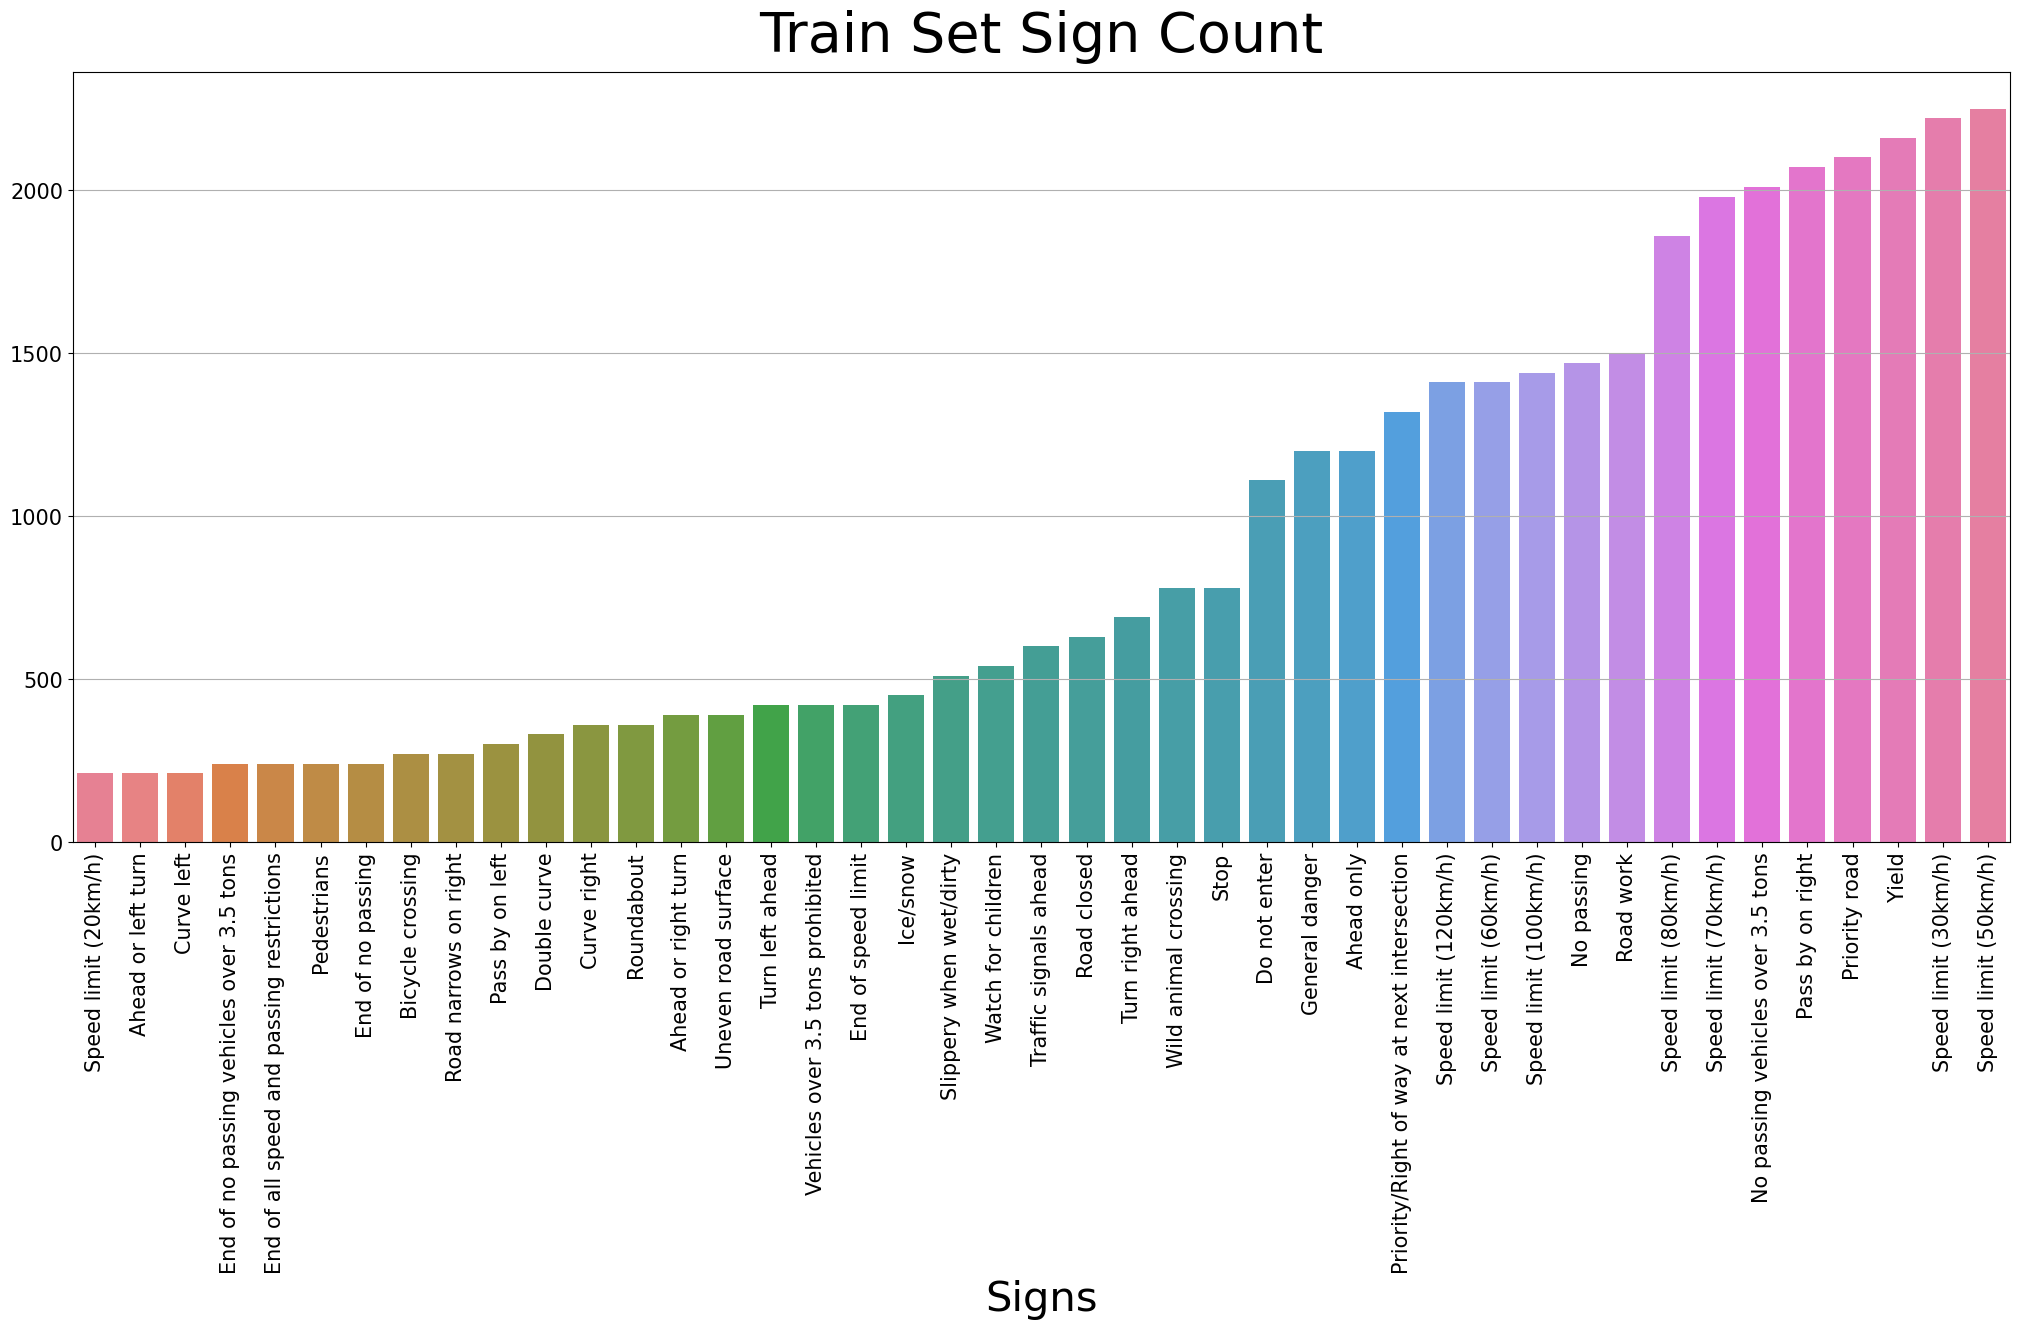

In [12]:
# Create training data graph
create_graph(trainDF, 'Train')

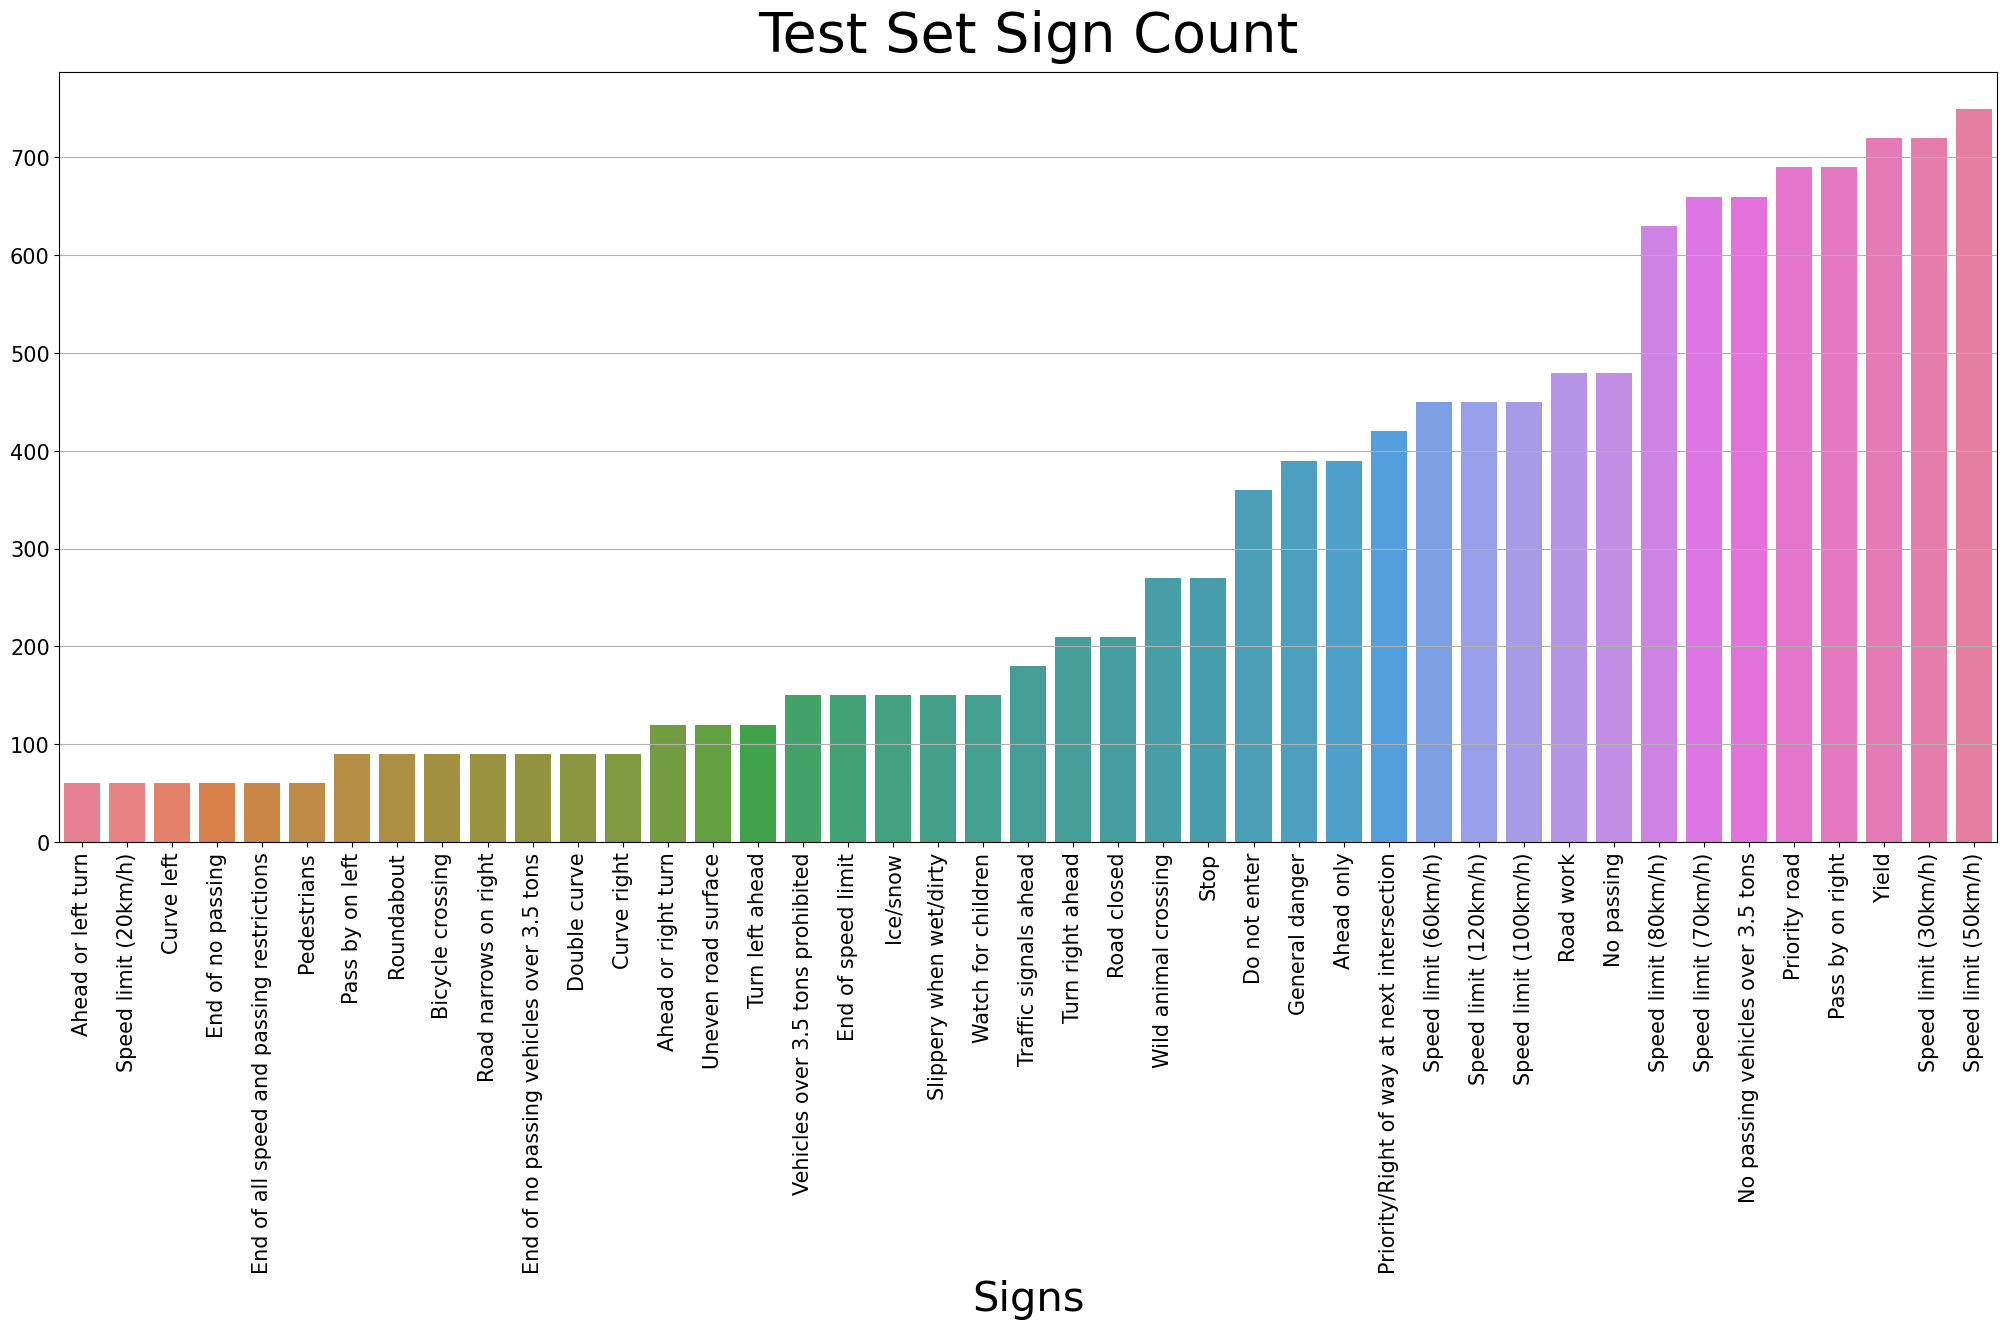

In [13]:
# Create testing data graph
create_graph(testDF, 'Test')

There is an imbalance of sign data in both the training set and the testing set, but the imbalance seems to be consistent, meaning the ratios in both datasets should be the same.

## Data Preprocessing and More EDA

The images need to be converted into a usable form for the model. The training data will be preprocessed first.

In [14]:
# Create empty lists to store the data
images = []
imgLabels = []

# For loop to iterate through all the folders and images in the training set
for i in range(categories):
    # Variables for the image filepath
    tempPath = train_path + '/' + str(i)
    imagePath = os.listdir(tempPath)
    
    # For loop to itertae through the images in each category
    for img in imagePath:
        # Create an array using the images and resize the image to 28x28
        tempArray = np.array(Image.open(tempPath+'/'+img).resize((28,28)))
        # Add the array to the image list created earlier
        images.append(tempArray)
        # Add the number label/ClassId to the label list created earlier
        imgLabels.append(i)

# Convert the lists into arrays
imageArray = np.array(images)
labelArray = np.array(imgLabels)

# Print the shapes of the arrays
print(imageArray.shape)
print(labelArray.shape)

(39209, 28, 28, 3)
(39209,)


In [15]:
# Split the data into training and validation sets for the model
#   Random state 42 will be used to keep training and testing consistent
X_train, X_valid, y_train, y_valid = train_test_split(imageArray, labelArray, test_size=0.3, random_state=42)

# Print out the shapes of the datasets
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(27446, 28, 28, 3)
(27446,)
(11763, 28, 28, 3)
(11763,)


#### Time to see what these images actaully look like.

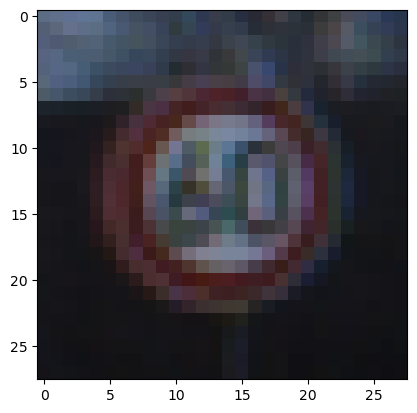

In [16]:
# Plot a random image from the training set
plt.imshow(X_train[random.randint(0, 27446)])
plt.show()

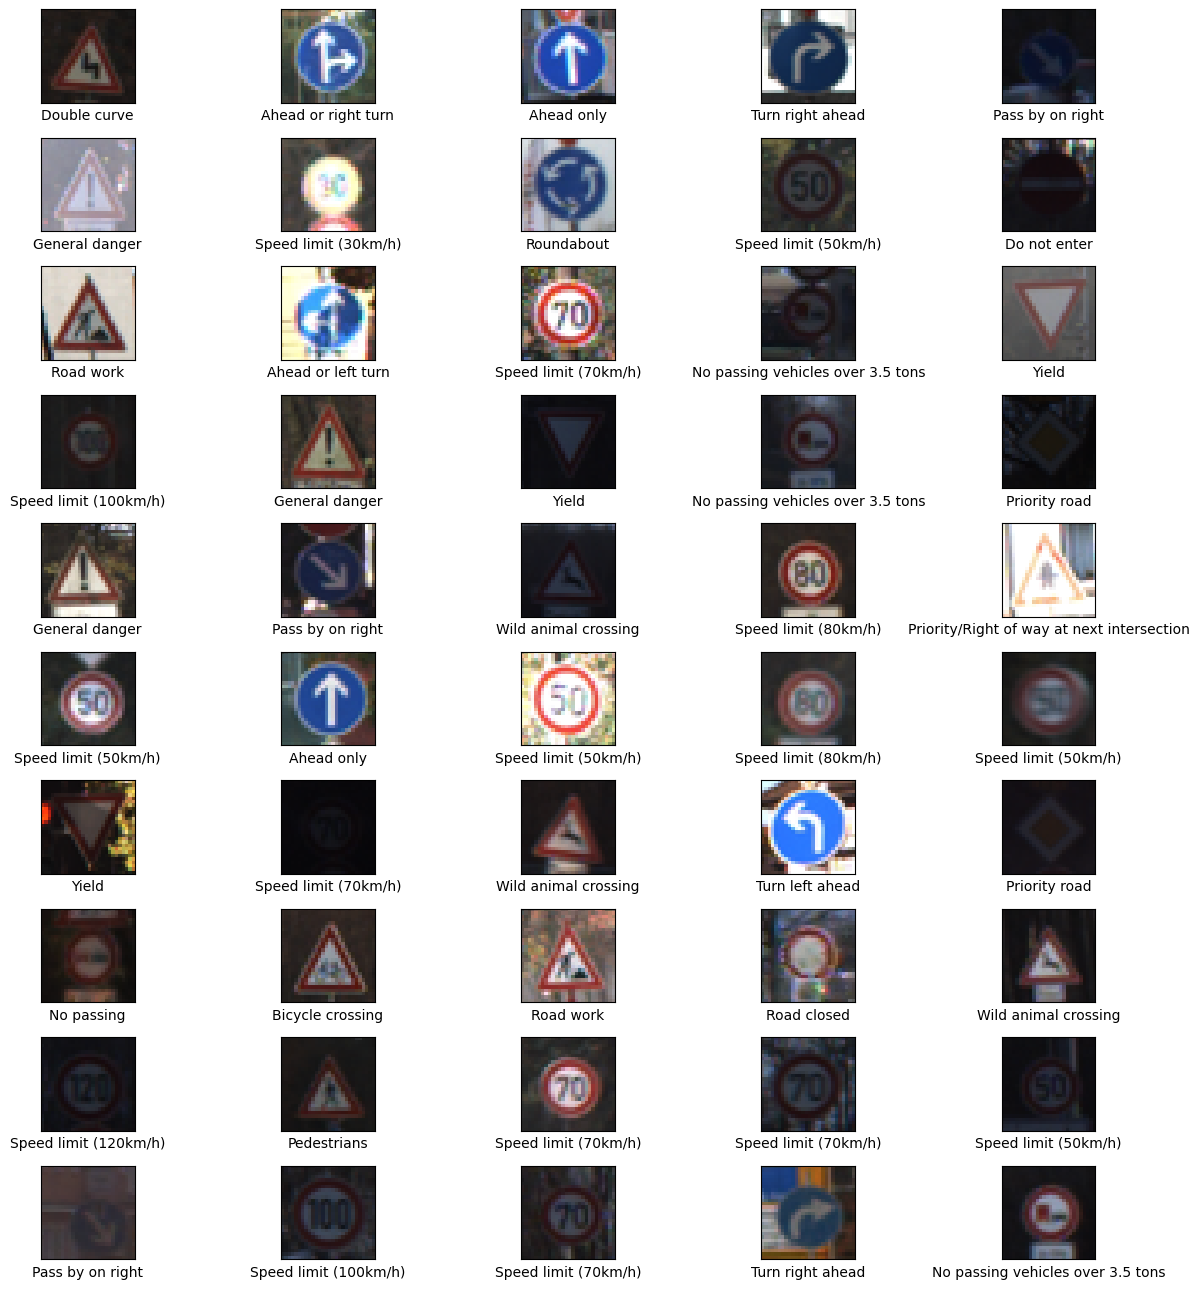

In [17]:
# Set figure size
plt.figure(figsize=(13,13))

# For loop to iterate through the images and create a subplot for each image with its label
for i in range(50):
    plt.subplot(10, 5, i+1)
    ax = plt.gca()
    plt.imshow(X_train[i])
    plt.xlabel(labels[y_train[i]])
    
    # Turn off tick labels
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    
    # Turn off tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()    
plt.show()

Continuing the rest of the preprocessing.

In [18]:
# Reshape the image data to the 28x28 pixel format
X_train = X_train.reshape(27446, 28, 28, 3).astype('float32')
X_valid = X_valid.reshape(11763, 28, 28, 3).astype('float32')

In [19]:
# Covert the pixel integers to floats
X_train /= 255
X_valid /= 255

In [20]:
# Transform the labels into one-hot encodings
y_train = to_categorical(y_train, categories)
y_valid = to_categorical(y_valid, categories)

The test data preprocessing is next.

In [21]:
# Create an empty list to store the new images
testData = []

# For loop to iterate through the images
for i in testDF["Path"]:
    tempPath = data_path + '/' + str(i)
    
    # Add the images to an array and resize them
    tempArray = np.array(Image.open(tempPath).resize((28,28)))
    # Add the array to the list
    testData.append(tempArray)

# Convert the list and label values into arrays
X_test = np.array(testData)
y_test = np.array(testDF["ClassId"].values)

# Print the array shapes
print(X_test.shape)
print(y_test.shape)

(12630, 28, 28, 3)
(12630,)


In [22]:
# Reshape the image array to the 28x28 pixel values
X_test = X_test.reshape(12630, 28, 28, 3).astype('float32')

# Convert the pixel values into floats
X_test /= 255

In [23]:
# Transform the labels using one-hot encoding
y_test = to_categorical(y_test, categories)

Both the training and testing data were preprocessed first so they could be used throughout the notebook. Each model will use the same preprocessed data.

# ANN

The Artificial Neural Network will be first. This is the most basic model of the three because it has simple Dense hidden layers with some flattening and dropout.Flattening will transform the multi-dimensional array into an one-dimensional array so the Dense layers can better comprehend it. Dropout will drop random nodes based on its probability value. This can eliminate nodes depending on each other too much and prevent overfitting.

The code block below is necessary for multiple sessions. This notebook will tune the models using the keras tuner. The keras tuner will create a folder filled with the trials it has done during the tuning process. An error will be given if the folder the keras tuner creates already exists. The code below will try to find the folder if it already exists and delete it.

In [27]:
# Import the necessary library
import shutil

# Define the folder that was created by the keras tuner
folder_path = "my_dir_ANN/intro_to_kt/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'my_dir_ANN/intro_to_kt/' has been deleted.


To save time, we will forgo creating and testing an initial model and instead go straight into hyperparameter tuning. The model used for tuning was based off the CNN in the last project.

In [28]:
# Function to test and tune the ANN's hyperparamters
def build_ANN(hp):
    # A Sequential model is used because images can be considered sequential data
    model = Sequential()
    # Dense layer and its possible values
    model.add(Dense(units=hp.Int('dense_1',
                                 min_value=32,
                                 max_value=128,
                                 step=16), 
                    activation='relu', 
                    input_shape=(28,28,3)))
    # Dropout layer and its possible values
    model.add(Dropout(hp.Choice('dropout_1',
                                values=[0.1,0.2,0.3,0.4,0.5])))
    # Flatten layer
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_2',
                                 min_value=32,
                                 max_value=128,
                                 step=16), 
                    activation='relu'))
    model.add(Dropout(hp.Choice('dropout_2',
                                values=[0.1,0.2,0.3,0.4,0.5])))
    # Softmax activation is used because it is great for multi-class problems
    #  Our dataset has 43 classes
    model.add(Dense(categories, activation='softmax'))
    
    # Compiling the model
    #  categorical_crossentropy - loss function for multi-class classification model where there are two or more output labels
    #  Adam - straightforward, general-use optimizer that produces great results consistently
    #  accuracy - how accurate the model is
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

In [29]:
# The tuner
#  Will use the function created earlier and create the folder with the trials
tuner_ANN = kt.Hyperband(build_ANN, objective='val_accuracy',
                         max_epochs=10, factor=3, 
                         directory='my_dir_ANN',
                         project_name='intro_to_kt')

In [30]:
# Implement early stopping
#  Will stop training before the model starts to overfit
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [31]:
# Perform the tuning
tuner_ANN.search(X_train, y_train, epochs=50, validation_split=0.3, callbacks=[stop_early])

Trial 30 Complete [00h 02m 47s]
val_accuracy: 0.9332038164138794

Best val_accuracy So Far: 0.9372115731239319
Total elapsed time: 00h 37m 57s


In [32]:
# Getting the best hyperparameters
best_hps_ANN = tuner_ANN.get_best_hyperparameters(num_trials=1)[0]

print(f"First Dense: {best_hps_ANN.get('dense_1')}")
print(f"First Dropout: {best_hps_ANN.get('dropout_1')}")
print(f"Second Dense: {best_hps_ANN.get('dense_2')}")
print(f"Second Dropout: {best_hps_ANN.get('dropout_2')}")

First Dense: 32
First Dropout: 0.2
Second Dense: 96
Second Dropout: 0.2


In [33]:
# Build a new model using the best hyperparameters
modelHT_ANN = tuner_ANN.hypermodel.build(best_hps_ANN)

# Model summary
modelHT_ANN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 28, 28, 32)        128       
                                                                 
 dropout_2 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 96)                2408544   
                                                                 
 dropout_3 (Dropout)         (None, 96)                0         
                                                                 
 dense_5 (Dense)             (None, 43)                4171      
                                                                 
Total params: 2412843 (9.20 MB)
Trainable params: 2412

In [34]:
# Perform the initial training
history_ANN = modelHT_ANN.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.3)

Epoch 1/50
601/601 [==============================] - 10s 16ms/step - loss: 2.3107 - accuracy: 0.3722 - val_loss: 1.3302 - val_accuracy: 0.6178
Epoch 2/50
601/601 [==============================] - 9s 15ms/step - loss: 1.2647 - accuracy: 0.6166 - val_loss: 0.9058 - val_accuracy: 0.7411
Epoch 3/50
601/601 [==============================] - 9s 15ms/step - loss: 0.9810 - accuracy: 0.6937 - val_loss: 0.6386 - val_accuracy: 0.8229
Epoch 4/50
601/601 [==============================] - 9s 15ms/step - loss: 0.8095 - accuracy: 0.7431 - val_loss: 0.6755 - val_accuracy: 0.8172
Epoch 5/50
601/601 [==============================] - 9s 15ms/step - loss: 0.7121 - accuracy: 0.7784 - val_loss: 0.4623 - val_accuracy: 0.8694
Epoch 6/50
601/601 [==============================] - 9s 15ms/step - loss: 0.6516 - accuracy: 0.7943 - val_loss: 0.4531 - val_accuracy: 0.8629
Epoch 7/50
601/601 [==============================] - 9s 15ms/step - loss: 0.5909 - accuracy: 0.8142 - val_loss: 0.4383 - val_accuracy: 0.877

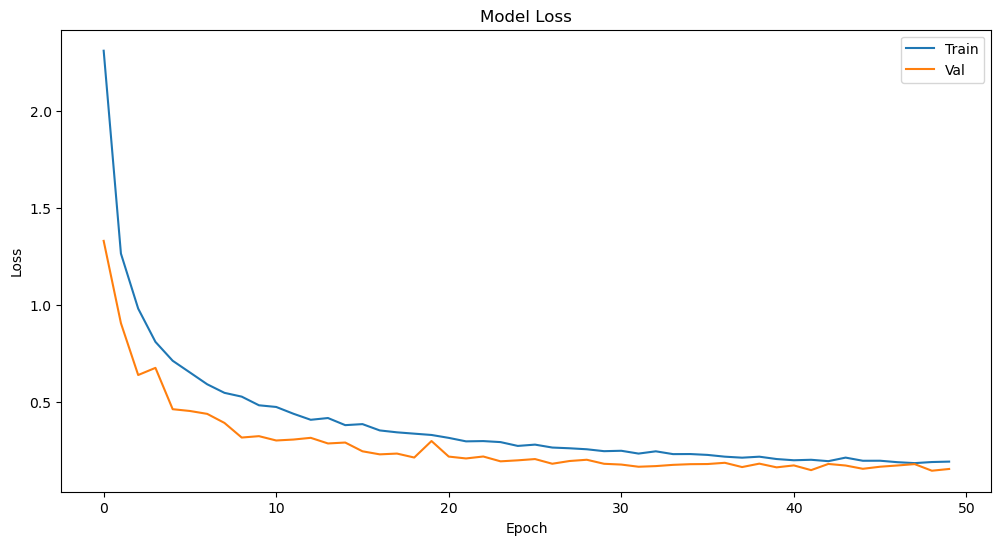

In [35]:
# Plot the loss
plt.figure(figsize=(12,6))
plt.plot(modelHT_ANN.history.history['loss'][:])
plt.plot(modelHT_ANN.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [36]:
# Find the best epoch amount based on the accuracy
val_acc_per_epoch_ANN = history_ANN.history['val_accuracy']
best_epoch_ANN = val_acc_per_epoch_ANN.index(max(val_acc_per_epoch_ANN)) + 1
print('Best epoch: %d' % (best_epoch_ANN,))

Best epoch: 49


In [37]:
# Final training using the best hyperparameters and epochs
hypermodel_ANN = tuner_ANN.hypermodel.build(best_hps_ANN)

hypermodel_ANN.fit(X_train, y_train, epochs=best_epoch_ANN, verbose=1, validation_split=0.3)

Epoch 1/49
601/601 [==============================] - 9s 15ms/step - loss: 2.4457 - accuracy: 0.3197 - val_loss: 1.4790 - val_accuracy: 0.5661
Epoch 2/49
601/601 [==============================] - 9s 15ms/step - loss: 1.4666 - accuracy: 0.5486 - val_loss: 0.9806 - val_accuracy: 0.7316
Epoch 3/49
601/601 [==============================] - 9s 15ms/step - loss: 1.1659 - accuracy: 0.6326 - val_loss: 0.8143 - val_accuracy: 0.7742
Epoch 4/49
601/601 [==============================] - 9s 15ms/step - loss: 1.0333 - accuracy: 0.6717 - val_loss: 0.6743 - val_accuracy: 0.8216
Epoch 5/49
601/601 [==============================] - 9s 15ms/step - loss: 0.9319 - accuracy: 0.7026 - val_loss: 0.6267 - val_accuracy: 0.8341
Epoch 6/49
601/601 [==============================] - 9s 15ms/step - loss: 0.8669 - accuracy: 0.7176 - val_loss: 0.5223 - val_accuracy: 0.8637
Epoch 7/49
601/601 [==============================] - 9s 15ms/step - loss: 0.8180 - accuracy: 0.7351 - val_loss: 0.5076 - val_accuracy: 0.8585

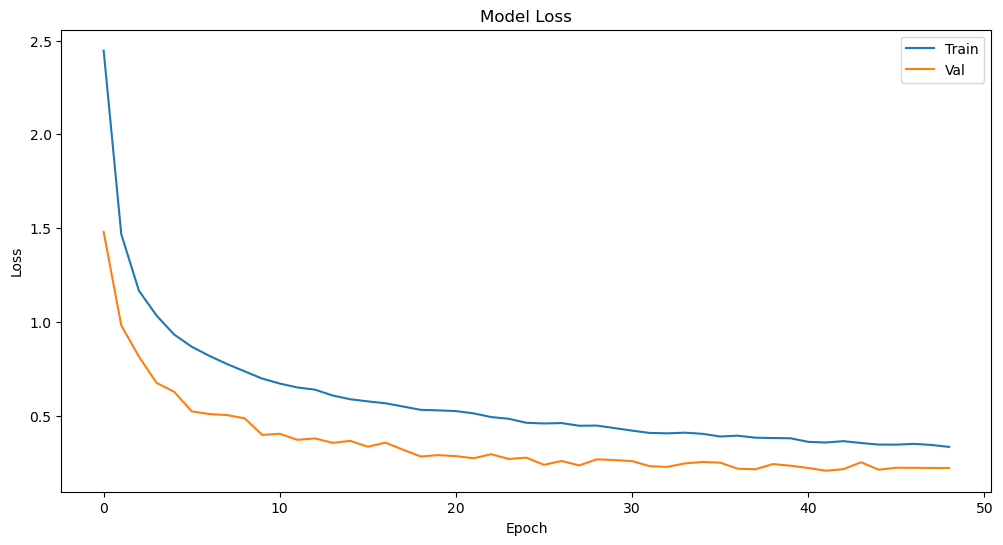

In [38]:
# Plot the loss
plt.figure(figsize=(12,6))
plt.plot(hypermodel_ANN.history.history['loss'][:])
plt.plot(hypermodel_ANN.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [39]:
# Evaluate the model using the testing data
loss_ANN, accuracy_ANN = hypermodel_ANN.evaluate(X_test, y_test)

print(f'\nLoss: {loss_ANN:.4f} \nAccuracy: {accuracy_ANN:.4f}')

395/395 [==============================] - 1s 2ms/step - loss: 0.7944 - accuracy: 0.8281

Loss: 0.7944 
Accuracy: 0.8281


We can see both the loss and accuracy are high. This means even though the model is accurate, there might be one or two categories that model incorrectly predicts more often than the others creating outliers and causing the loss to skyrocket. We can identify the problem using a confusion matrix and see how well the model performed in general.

In [40]:
# Function to create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observation')
    plt.xlabel('Prediction')

395/395 [==============================] - 1s 2ms/step


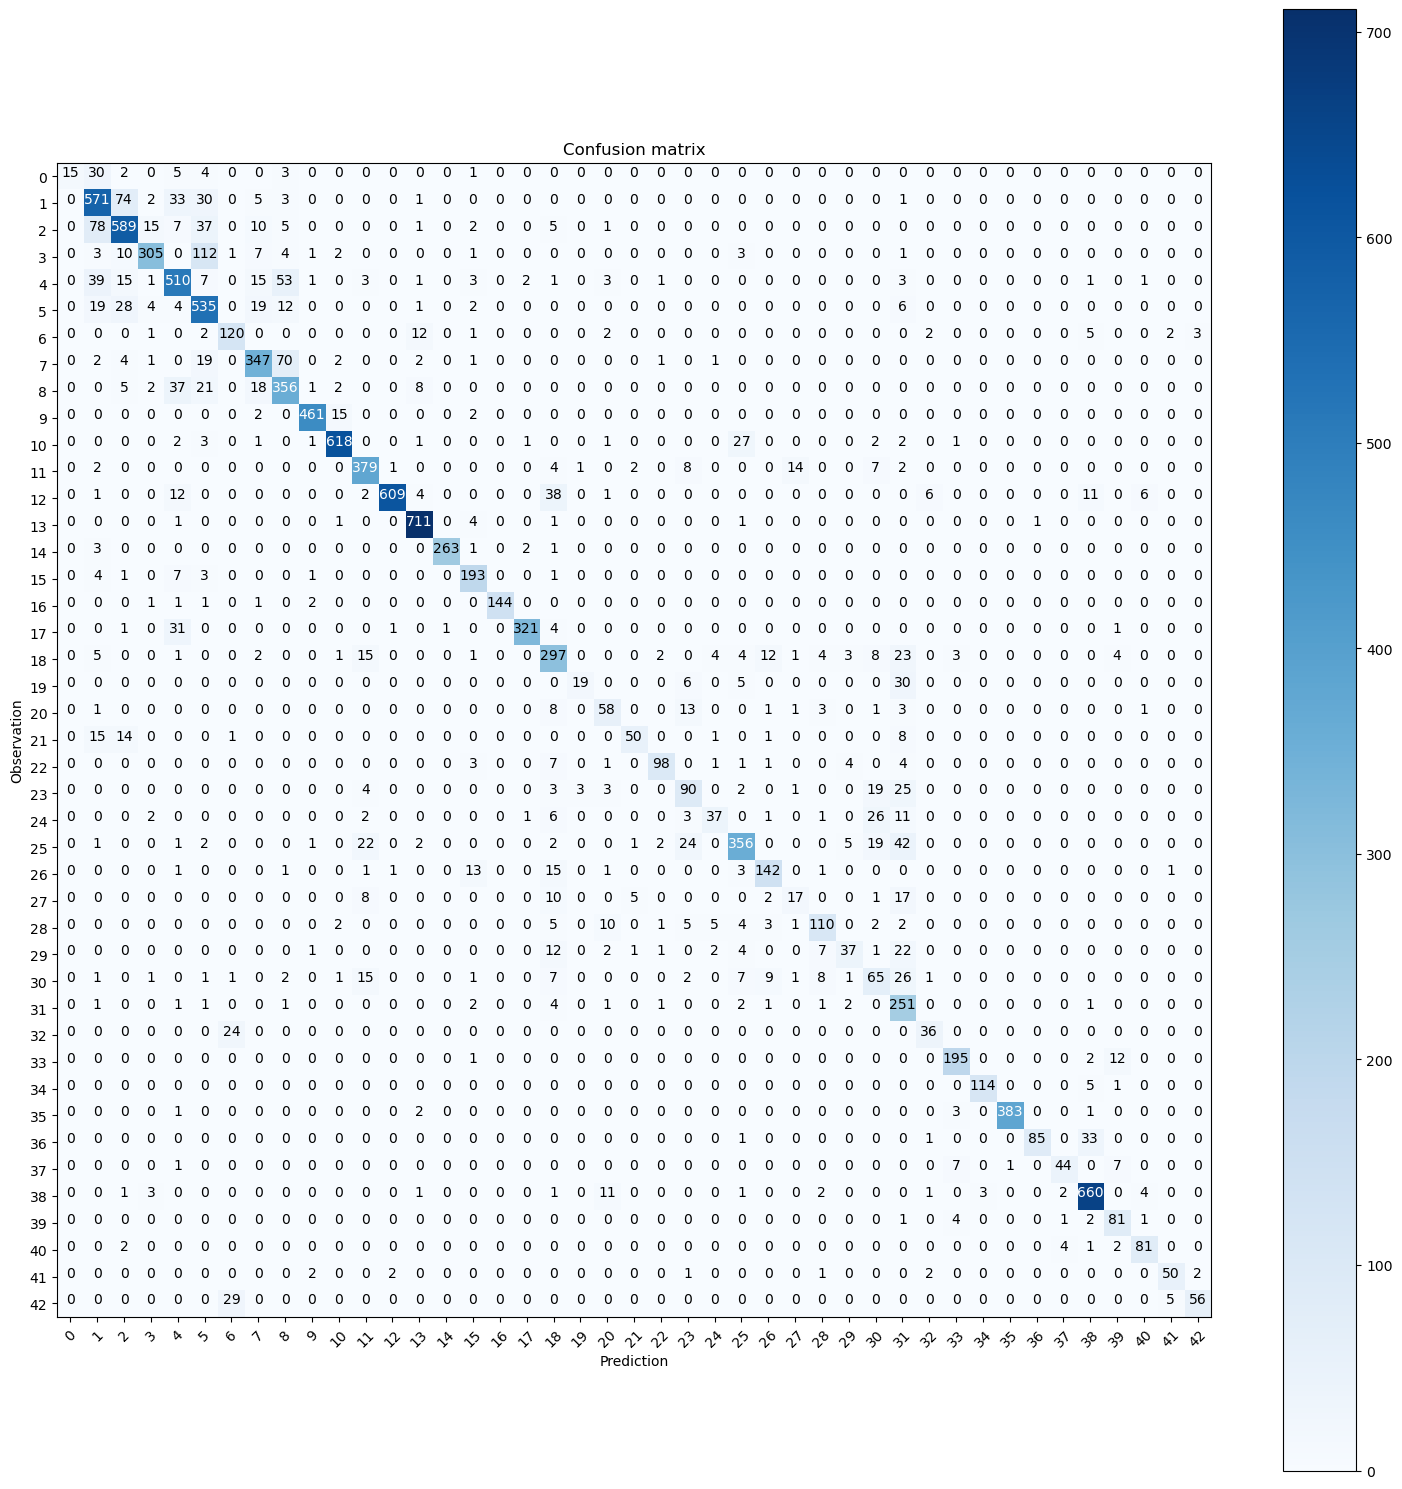

In [41]:
# Get model predictions
Y_pred = hypermodel_ANN.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(confusion_mtx, classes = range(43))

The initial assumption of why the loss was so high seems to be correct. Category 3 was misidentified as category 5 112 times There are a couple other high misidentifications like categories 1, 2, and 7. This most likely resulted in the outliers that hijacked the loss.

In [42]:
# Custom legend
for key, value in labels.items():
    print(f'{key}: {value}')

0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing vehicles over 3.5 tons
11: Priority/Right of way at next intersection
12: Priority road
13: Yield
14: Stop
15: Road closed
16: Vehicles over 3.5 tons prohibited
17: Do not enter
18: General danger
19: Curve left
20: Curve right
21: Double curve
22: Uneven road surface
23: Slippery when wet/dirty
24: Road narrows on right
25: Road work
26: Traffic signals ahead
27: Pedestrians
28: Watch for children
29: Bicycle crossing
30: Ice/snow
31: Wild animal crossing
32: End of all speed and passing restrictions
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Ahead or right turn
37: Ahead or left turn
38: Pass by on right
39: Pass by on left
40: Roundabout
41: End of no passing
42: End of no passing vehicles over 3.5 tons


The incorrect data will be visualized to further understand what happened.

In [43]:
# Get the predictions
predictions_ANN = hypermodel_ANN.predict(X_test)

395/395 [==============================] - 1s 2ms/step


In [44]:
# Create an empty list to store the incorrect predictions
incorrect_predictions_ANN = []

# For loop to iterate through the predictions
for i, (p, e) in enumerate(zip(predictions_ANN, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)
    
    # Add the incorrect predictions to the list
    if predicted != expected:
        incorrect_predictions_ANN.append((i, X_test[i], predicted, expected))
        
# Print the amount of incorrect predictions
print(len(incorrect_predictions_ANN))

2171


#### The ANN model had 2,171 incorrect identifications.

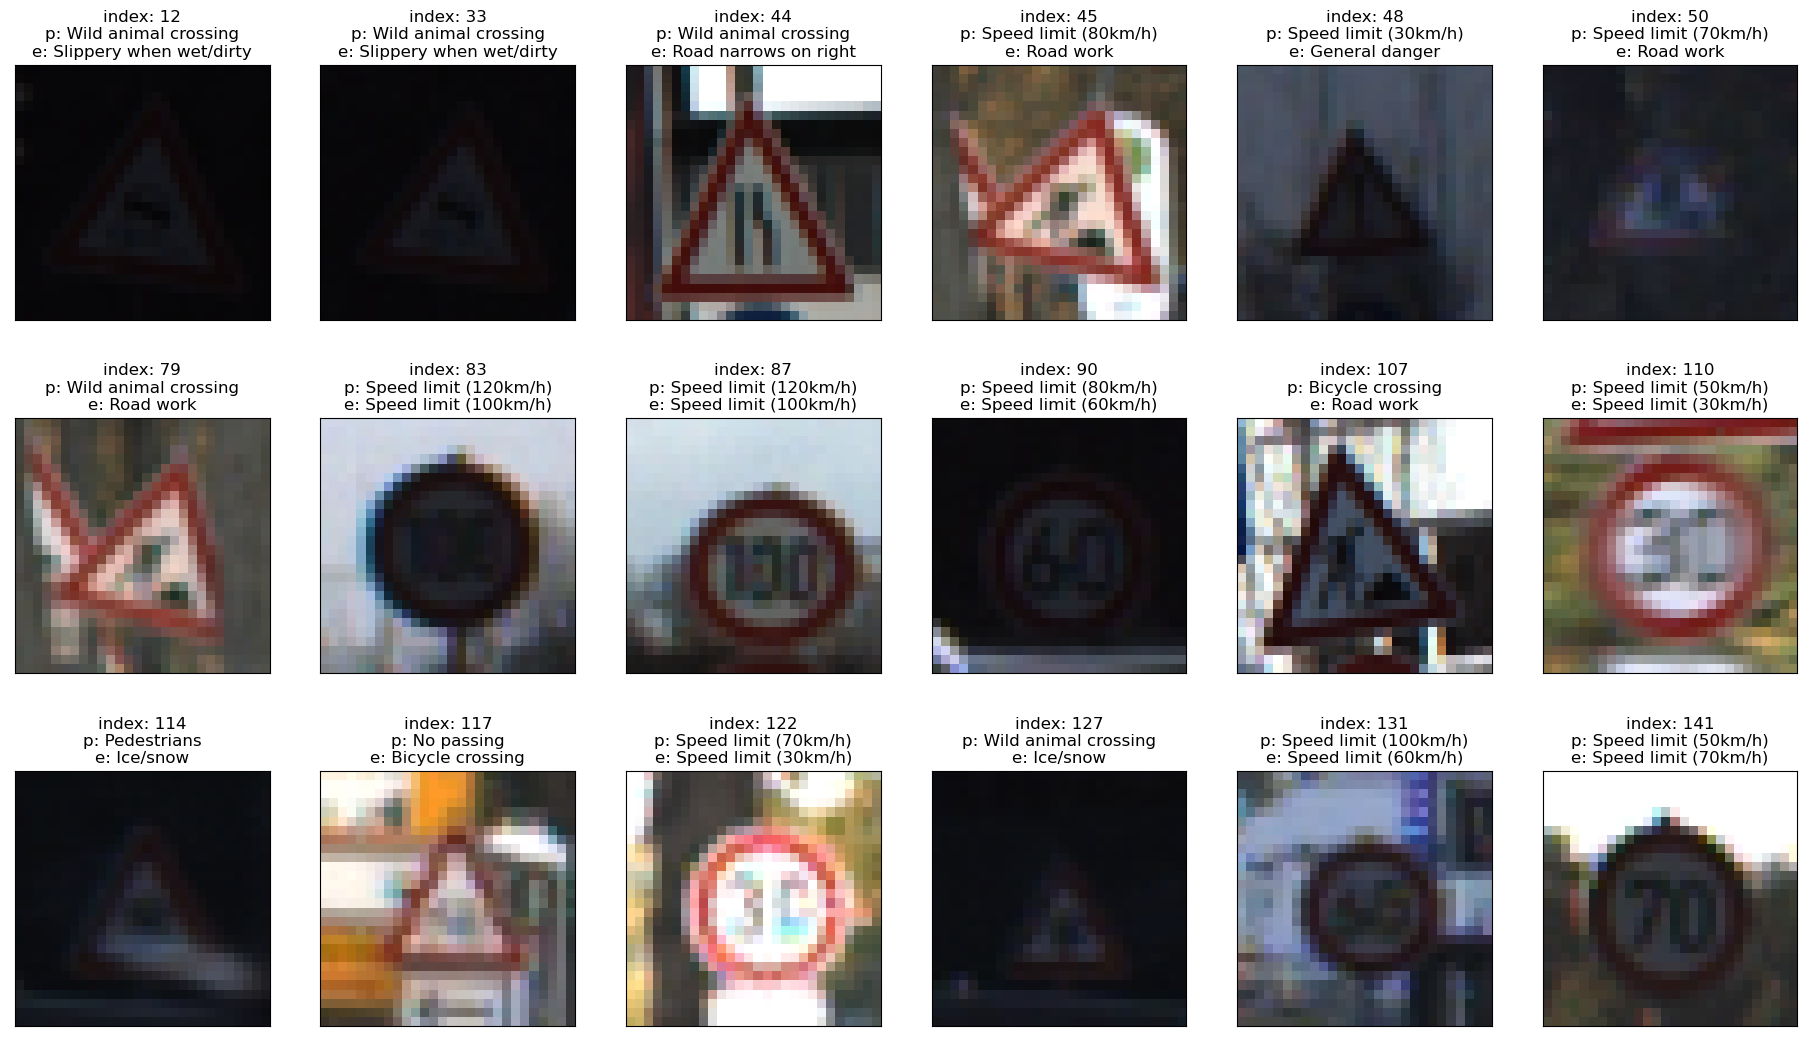

In [45]:
# Define the subplots to display the images
figure, axes = plt.subplots(nrows=3, ncols=6, figsize=(23,13))

# For loop to iterate through the incorrect predictions and display the images in the subplots
for axes, item in zip(axes.ravel(), incorrect_predictions_ANN):
    index, image, predicted, expected = item
    axes.imshow(image)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'index: {index}\np: {labels[predicted]}\ne: {labels[expected]}')

plt.show()

# CNN

Next will be the Convolutional Neural Network. This is the preferred choice when dealing with image classification. Many of the parameters will be the same as the ANN, but now convolutional and pooling layers will be introduced to the model. The convolutional layers will scan over the image in a square pattern defined by the kernel and get th pixel values to understand the important features of the image. The pooling layers will essentially summarize the image's features extracted by the convolutional layer and help reduce the computing time.

In [49]:
# Define the folder that was created by the keras tuner
folder_path = "my_dir_CNN/intro_to_kt/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'my_dir_CNN/intro_to_kt/' has been deleted.


In [50]:
# Function to test and tune the CNN's hyperparamters
def build_CNN(hp):
    model = Sequential()
    
    # Convolutional layer and its possible values
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,3)))
    
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'))
    
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hp.Choice('dropout_1',
                                values=[0.1,0.2,0.3,0.4,0.5])))
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'))

    model.add(Dropout(hp.Choice('dropout_2',
                                values=[0.1,0.2,0.3,0.4,0.5])))
    
    model.add(Dense(categories, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [51]:
# The tuner
#  Will use the function created earlier and create the folder with the trials
tuner_CNN = kt.Hyperband(build_CNN, objective='val_accuracy',
                         max_epochs=10, factor=3, 
                         directory='my_dir_CNN',
                         project_name='intro_to_kt')

In [52]:
# Implement early stopping
#  Will stop training before the model starts to overfit
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [53]:
# Perform the tuning
tuner_CNN.search(X_train, y_train, epochs=50, validation_split=0.3, callbacks=[stop_early])

Trial 30 Complete [00h 02m 02s]
val_accuracy: 0.9916201233863831

Best val_accuracy So Far: 0.9950206279754639
Total elapsed time: 00h 16m 48s


In [55]:
# Get the best hyper parameters
best_hps_CNN = tuner_CNN.get_best_hyperparameters(num_trials=1)[0]

print(f"First convolutional layer: {best_hps_CNN.get('conv_1_filter')}")
print(f"First convolutional kernel: {best_hps_CNN.get('conv_1_kernel')}")
print(f"Second convolutional layer: {best_hps_CNN.get('conv_2_filter')}")
print(f"Second convolutional kernel: {best_hps_CNN.get('conv_2_kernel')}")
print(f"Third convolutional layer: {best_hps_CNN.get('conv_3_filter')}")
print(f"Third convolutional kernel: {best_hps_CNN.get('conv_3_kernel')}")
print(f"First dropout: {best_hps_CNN.get('dropout_1')}")
print(f"Dense neurons: {best_hps_CNN.get('dense_1_units')}")
print(f"Second dropout: {best_hps_CNN.get('dropout_2')}")

First convolutional layer: 48
First convolutional kernel: 5
Second convolutional layer: 64
Second convolutional kernel: 5
Third convolutional layer: 48
Third convolutional kernel: 5
First dropout: 0.3
Dense neurons: 64
Second dropout: 0.3


In [56]:
# Build the new model with the best hyperparameters
modelHT_CNN = tuner_CNN.hypermodel.build(best_hps_CNN)

# Model summary
modelHT_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 48)        3648      
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 64)        76864     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 48)          76848     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 48)          0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 3, 3, 48)         

In [57]:
# Perform the initial training
history_CNN = modelHT_CNN.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.3)

Epoch 1/50
601/601 [==============================] - 9s 13ms/step - loss: 1.9247 - accuracy: 0.4595 - val_loss: 0.4762 - val_accuracy: 0.8760
Epoch 2/50
601/601 [==============================] - 8s 13ms/step - loss: 0.5981 - accuracy: 0.8158 - val_loss: 0.2091 - val_accuracy: 0.9587
Epoch 3/50
601/601 [==============================] - 8s 13ms/step - loss: 0.3456 - accuracy: 0.8954 - val_loss: 0.1044 - val_accuracy: 0.9713
Epoch 4/50
601/601 [==============================] - 8s 13ms/step - loss: 0.2468 - accuracy: 0.9230 - val_loss: 0.0760 - val_accuracy: 0.9801
Epoch 5/50
601/601 [==============================] - 8s 13ms/step - loss: 0.1899 - accuracy: 0.9403 - val_loss: 0.0631 - val_accuracy: 0.9866
Epoch 6/50
601/601 [==============================] - 8s 13ms/step - loss: 0.1564 - accuracy: 0.9522 - val_loss: 0.0630 - val_accuracy: 0.9845
Epoch 7/50
601/601 [==============================] - 8s 13ms/step - loss: 0.1343 - accuracy: 0.9599 - val_loss: 0.0650 - val_accuracy: 0.9815

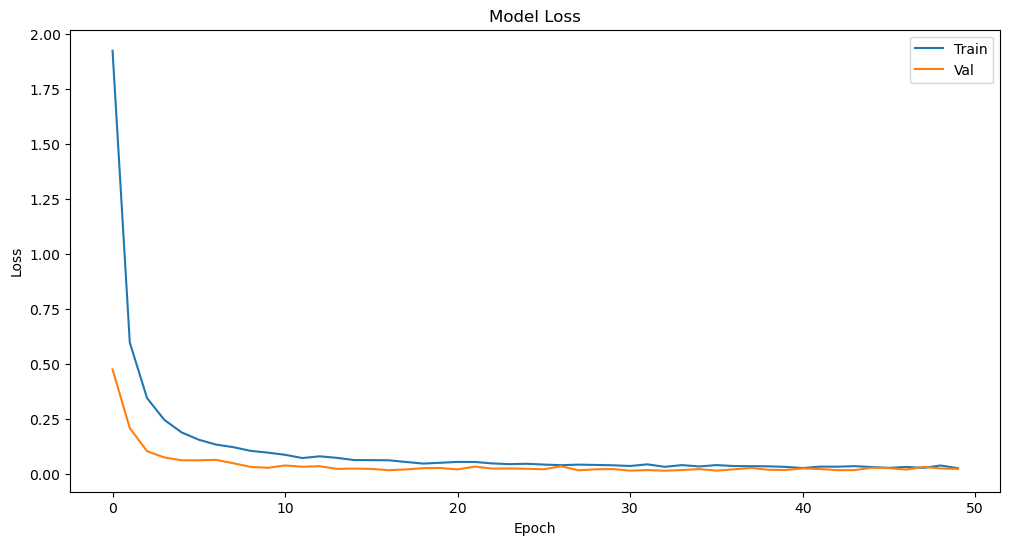

In [59]:
# Plot the loss
plt.figure(figsize=(12,6))
plt.plot(modelHT_CNN.history.history['loss'][:])
plt.plot(modelHT_CNN.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [60]:
# Find the best epoch
val_acc_per_epoch_CNN = history_CNN.history['val_accuracy']
best_epoch_CNN = val_acc_per_epoch_CNN.index(max(val_acc_per_epoch_CNN)) + 1
print('Best epoch: %d' % (best_epoch_CNN,))

Best epoch: 43


In [61]:
# Final training using the best hyperparameters and epochs
hypermodel_CNN = tuner_CNN.hypermodel.build(best_hps_CNN)

hypermodel_CNN.fit(X_train, y_train, epochs=best_epoch_CNN, verbose=1, validation_split=0.3)

Epoch 1/43
601/601 [==============================] - 8s 13ms/step - loss: 2.0908 - accuracy: 0.4356 - val_loss: 0.4658 - val_accuracy: 0.8611
Epoch 2/43
601/601 [==============================] - 8s 13ms/step - loss: 0.5567 - accuracy: 0.8298 - val_loss: 0.1716 - val_accuracy: 0.9545
Epoch 3/43
601/601 [==============================] - 8s 13ms/step - loss: 0.3279 - accuracy: 0.8993 - val_loss: 0.1092 - val_accuracy: 0.9709
Epoch 4/43
601/601 [==============================] - 8s 13ms/step - loss: 0.2323 - accuracy: 0.9297 - val_loss: 0.0921 - val_accuracy: 0.9745
Epoch 5/43
601/601 [==============================] - 8s 13ms/step - loss: 0.1869 - accuracy: 0.9428 - val_loss: 0.0743 - val_accuracy: 0.9809
Epoch 6/43
601/601 [==============================] - 8s 13ms/step - loss: 0.1555 - accuracy: 0.9547 - val_loss: 0.0521 - val_accuracy: 0.9863
Epoch 7/43
601/601 [==============================] - 8s 13ms/step - loss: 0.1401 - accuracy: 0.9571 - val_loss: 0.0468 - val_accuracy: 0.9879

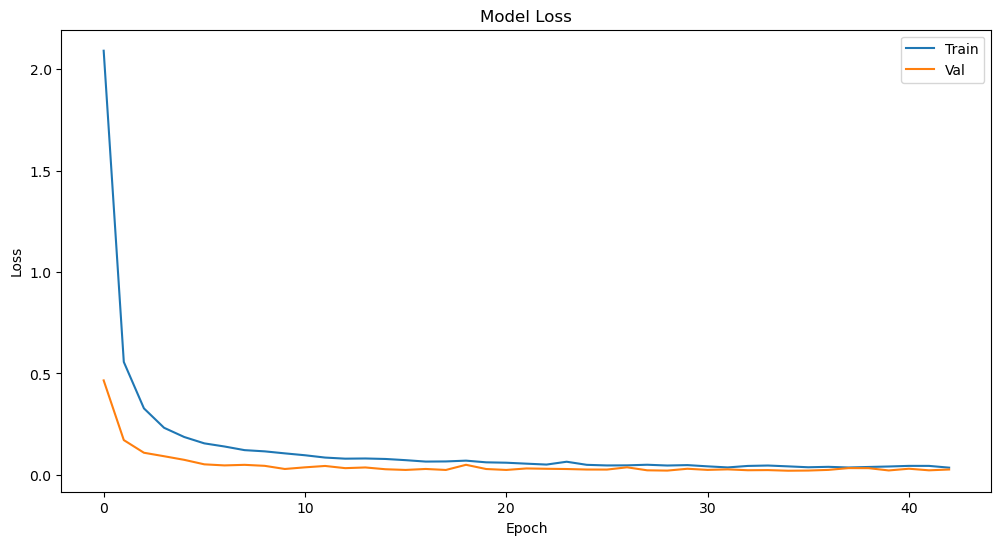

In [62]:
# Plot the loss
plt.figure(figsize=(12,6))
plt.plot(hypermodel_CNN.history.history['loss'][:])
plt.plot(hypermodel_CNN.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [63]:
# Evaluate the model using the testing data
loss_CNN, accuracy_CNN = hypermodel_CNN.evaluate(X_test, y_test)

print(f'\nLoss: {loss_CNN:.4f} \nAccuracy: {accuracy_CNN:.4f}')

395/395 [==============================] - 2s 4ms/step - loss: 0.1996 - accuracy: 0.9672

Loss: 0.1996 
Accuracy: 0.9672


#### The loss is a lot lower and the accuracy is higher than the ANN. As expected, the CNN is performing better than the basic ANN.

We'll plot a confusion matrix and find the amount of the incorrect predictions like the ANN to be sure.

395/395 [==============================] - 2s 4ms/step


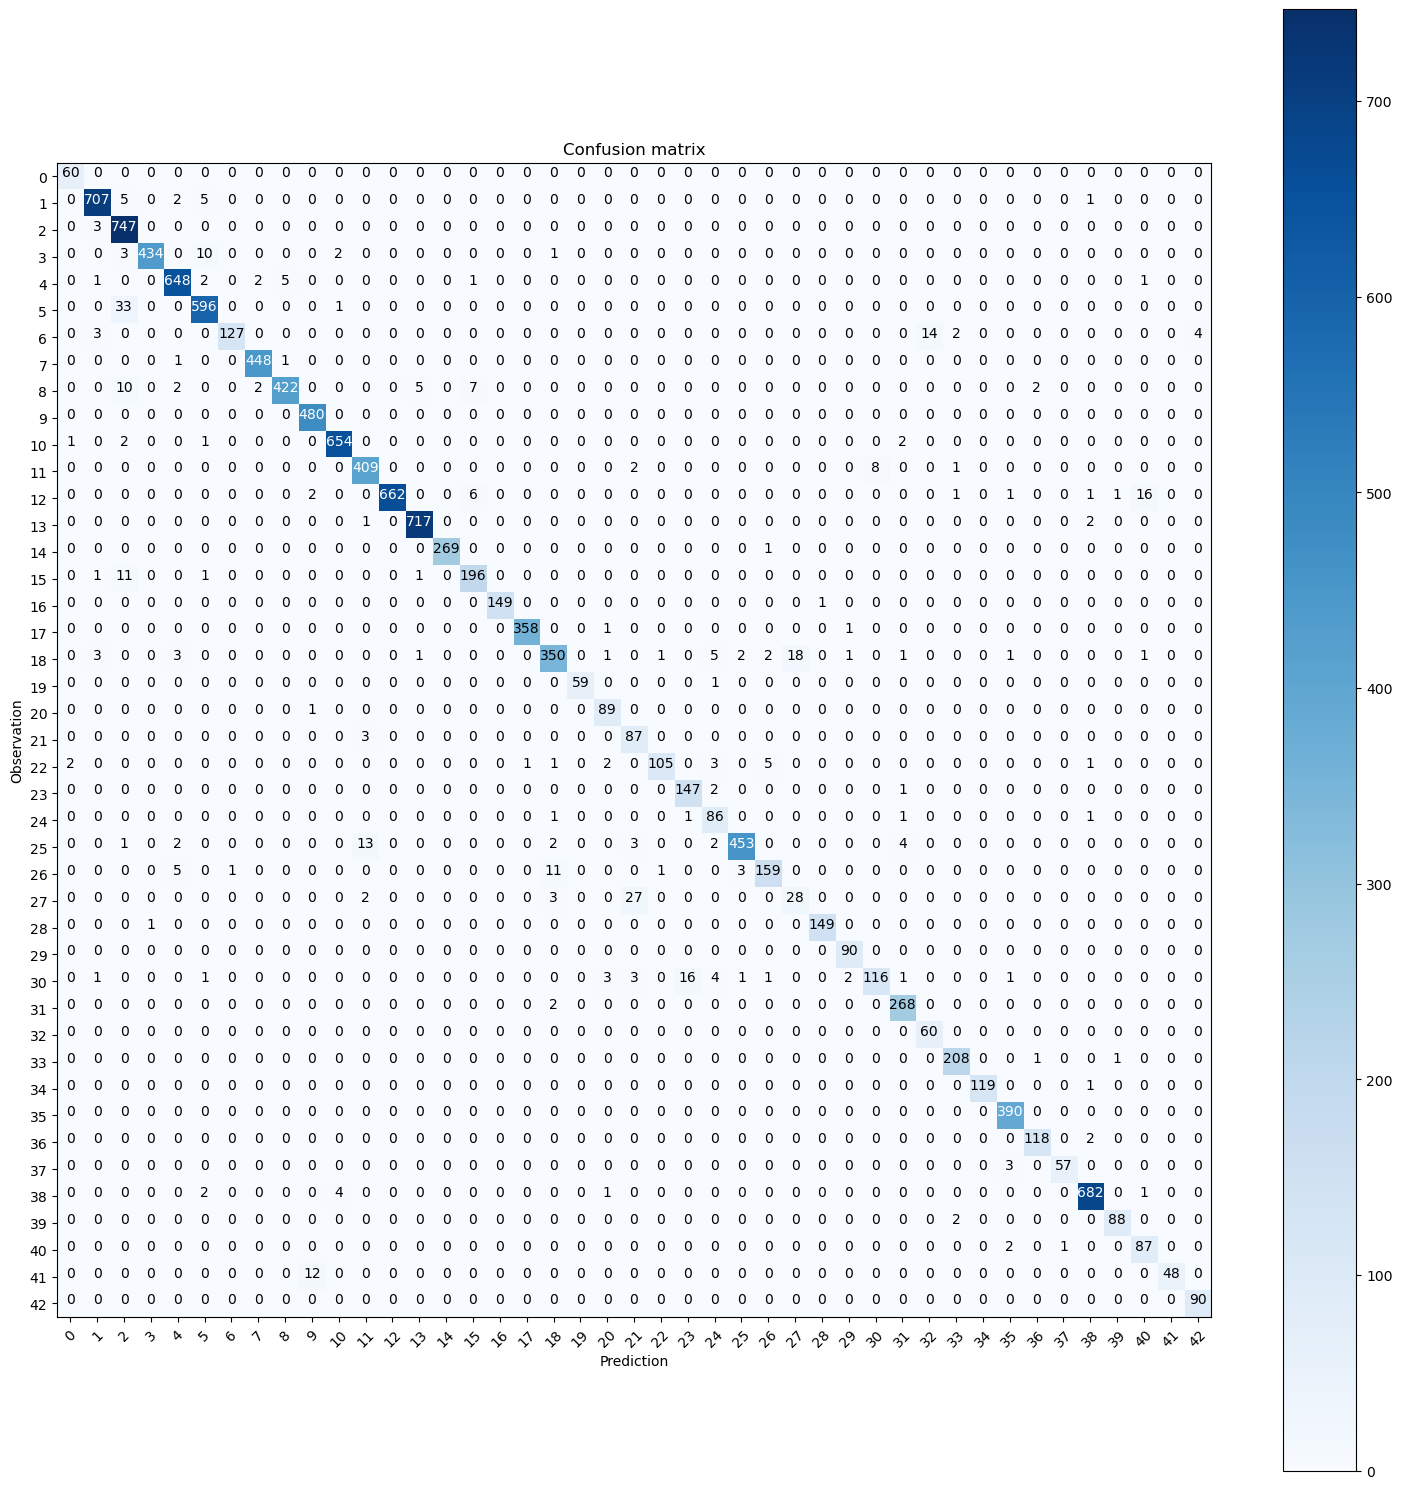

In [64]:
# Get model predictions
Y_pred = hypermodel_CNN.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(confusion_mtx, classes = range(43))

In [65]:
# Custom legend
for key, value in labels.items():
    print(f'{key}: {value}')

0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing vehicles over 3.5 tons
11: Priority/Right of way at next intersection
12: Priority road
13: Yield
14: Stop
15: Road closed
16: Vehicles over 3.5 tons prohibited
17: Do not enter
18: General danger
19: Curve left
20: Curve right
21: Double curve
22: Uneven road surface
23: Slippery when wet/dirty
24: Road narrows on right
25: Road work
26: Traffic signals ahead
27: Pedestrians
28: Watch for children
29: Bicycle crossing
30: Ice/snow
31: Wild animal crossing
32: End of all speed and passing restrictions
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Ahead or right turn
37: Ahead or left turn
38: Pass by on right
39: Pass by on left
40: Roundabout
41: End of no passing
42: End of no passing vehicles over 3.5 tons


In [66]:
# Get the predictions
predictions_CNN = hypermodel_CNN.predict(X_test)

395/395 [==============================] - 2s 4ms/step


In [67]:
# Create an empty list to store the incorrect predictions
incorrect_predictions_CNN = []

# For loop to iterate through the predictions
for i, (p, e) in enumerate(zip(predictions_CNN, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)
    
    # Add the incorrect predictions to the list
    if predicted != expected:
        incorrect_predictions_CNN.append((i, X_test[i], predicted, expected))
        
# Print the amount of incorrect predictions
print(len(incorrect_predictions_CNN))

414


#### The CNN model had 414 incorrect predictions. A lot less than the ANN.

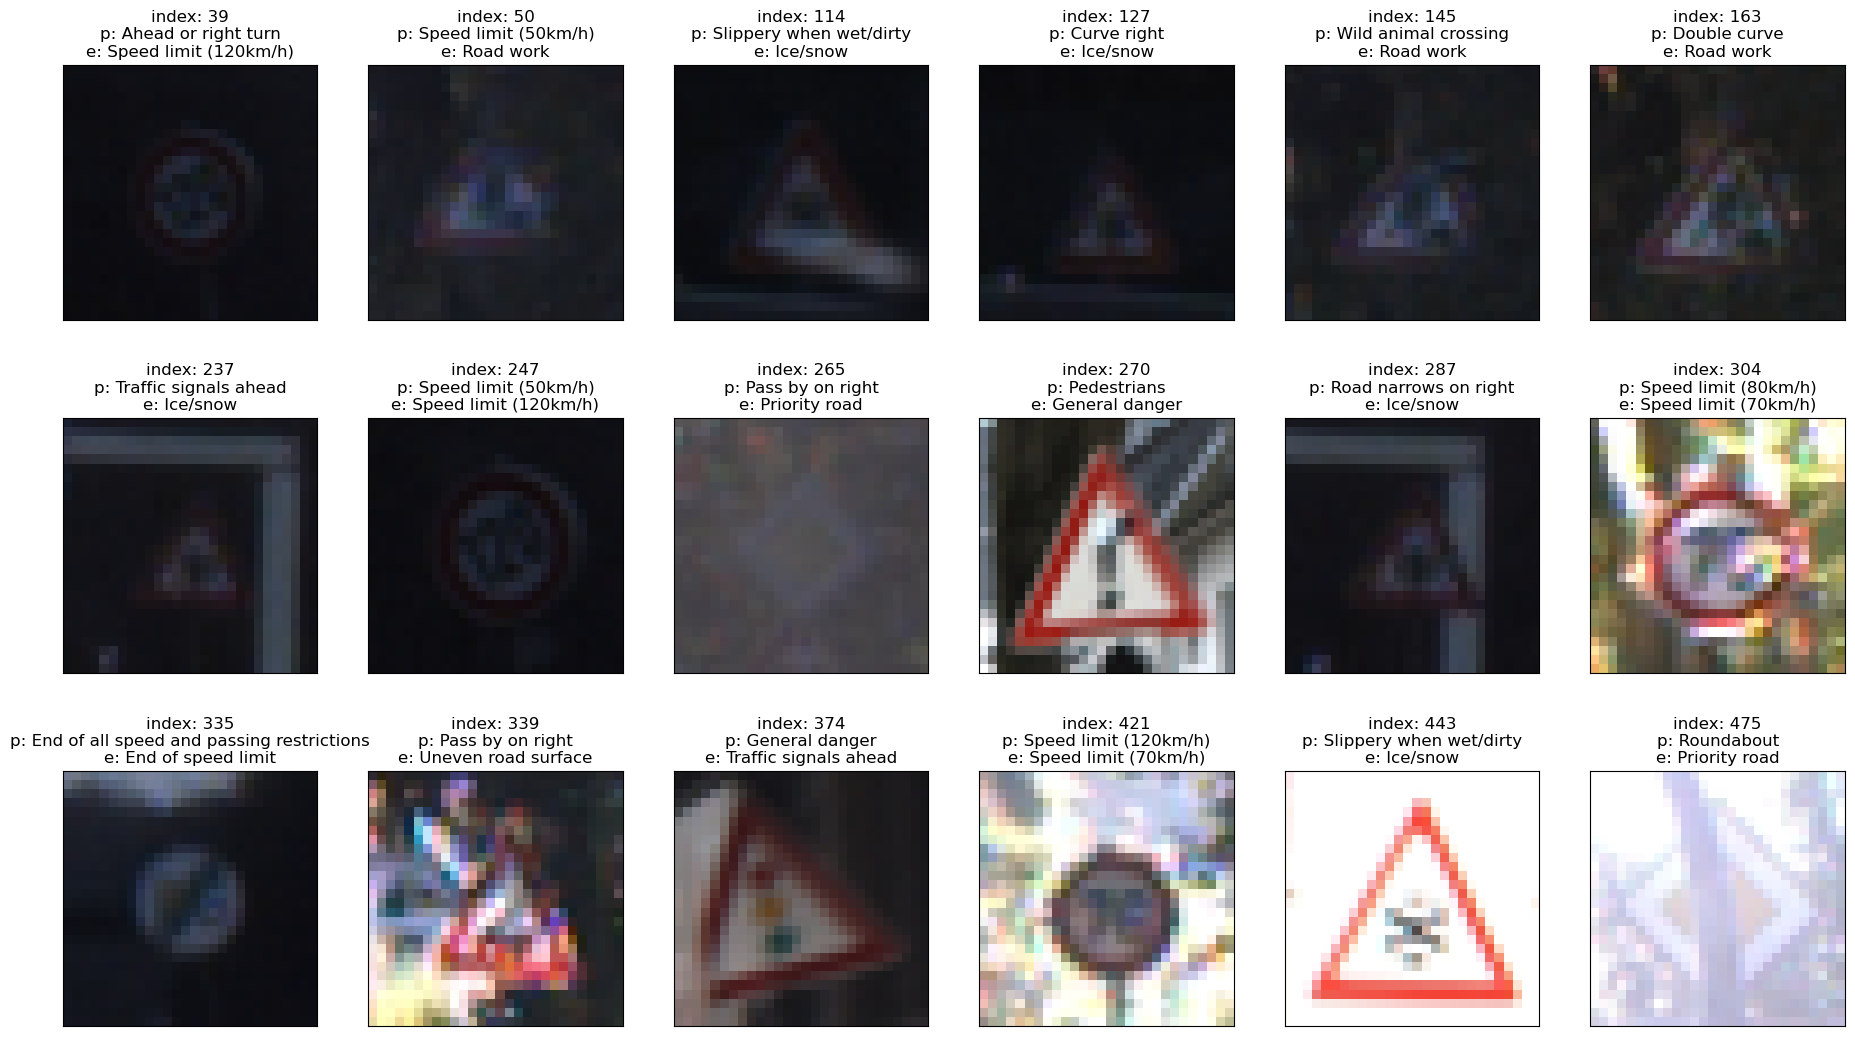

In [68]:
# Define the subplots to display the images
figure, axes = plt.subplots(nrows=3, ncols=6, figsize=(23,13))

# For loop to iterate through the incorrect predictions and display the images in the subplots
for axes, item in zip(axes.ravel(), incorrect_predictions_CNN):
    index, image, predicted, expected = item
    axes.imshow(image)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'index: {index}\np: {labels[predicted]}\ne: {labels[expected]}')

plt.show()

# Autoencoder

Autoencoders are not necessarily used for image classification. Instead they are used more for image restoration and denoising as well as other tasks. It is comprosed of two parts, the encoder and decoder. The encoder will compress the image, while the decoder will try to restore it to its original resolution.

For this comparison, we will see how well an autoencoder can restore the images.

The encoder will have similar layers and parameters to the CNN, while the decoder will have a new layer called upsampling. Upsampling will try to revert the pooling an return the image to its regular resolution.

In [69]:
# Function to create the encoder
def encoder(input_img):
    x = Conv2D(112, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoder = MaxPooling2D((2, 2), padding='same')(x)

    return encoder

# Function to create the decoder
def decoder(encoder):    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return decoded

In [70]:
# Create a variable for the amount of noise added to the image
noise_factor = 1

In [71]:
# Add some noise to the data sets
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [72]:
print(X_train_noisy.shape)
print(X_valid_noisy.shape)
print(X_test_noisy.shape)

(27446, 28, 28, 3)
(11763, 28, 28, 3)
(12630, 28, 28, 3)


In [73]:
# Define the shapes of our images for the autoencoder
input_img = Input(shape = (28, 28, 3))

# Create the autoencoder using a basic model
autoencoder = Model(input_img, decoder(encoder(input_img)))
# Instead of accuracy, MSE will be measured instead since this isn't a classification problem
autoencoder.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics=['mse'])

In [74]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 112)       3136      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 112)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        64576     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 64)          0     

In [75]:
# Train the model
history_AE = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_valid_noisy, X_valid))

Epoch 1/50
215/215 [==============================] - 10s 45ms/step - loss: 0.5538 - mse: 0.0399 - val_loss: 0.5393 - val_mse: 0.0330
Epoch 2/50
215/215 [==============================] - 9s 42ms/step - loss: 0.5227 - mse: 0.0261 - val_loss: 0.5203 - val_mse: 0.0244
Epoch 3/50
215/215 [==============================] - 9s 41ms/step - loss: 0.5122 - mse: 0.0220 - val_loss: 0.5179 - val_mse: 0.0234
Epoch 4/50
215/215 [==============================] - 9s 41ms/step - loss: 0.5096 - mse: 0.0210 - val_loss: 0.5161 - val_mse: 0.0227
Epoch 5/50
215/215 [==============================] - 9s 41ms/step - loss: 0.5081 - mse: 0.0205 - val_loss: 0.5161 - val_mse: 0.0228
Epoch 6/50
215/215 [==============================] - 9s 41ms/step - loss: 0.5071 - mse: 0.0201 - val_loss: 0.5127 - val_mse: 0.0214
Epoch 7/50
215/215 [==============================] - 9s 41ms/step - loss: 0.5065 - mse: 0.0199 - val_loss: 0.5157 - val_mse: 0.0224
Epoch 8/50
215/215 [==============================] - 9s 41ms/step -

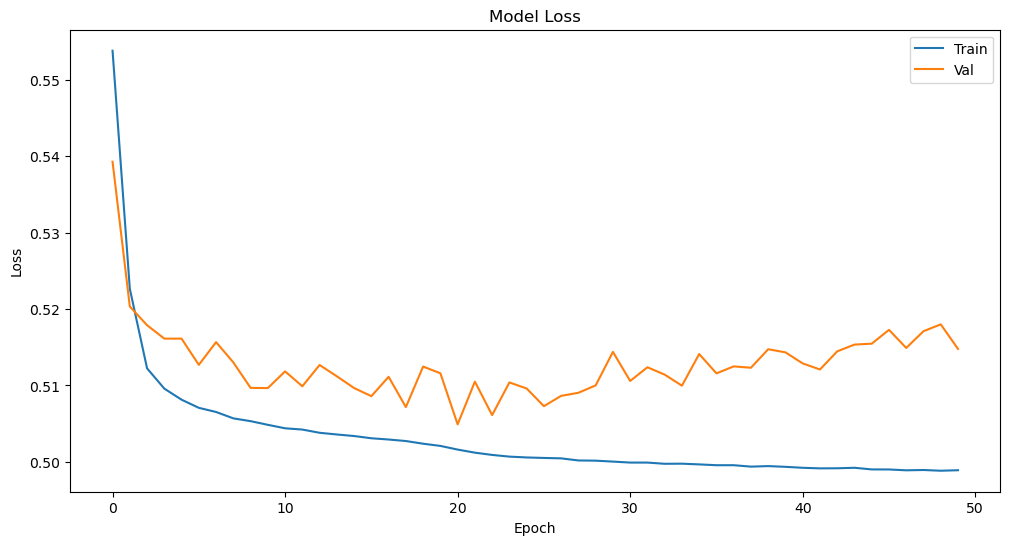

In [76]:
# Plot the loss
plt.figure(figsize=(12,6))
plt.plot(history_AE.history['loss'][:])
plt.plot(history_AE.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [78]:
# Evaluate the model using the test data
loss_AE, mse_AE = autoencoder.evaluate(X_test_noisy, X_test)

print(f'\nLoss: {loss_AE:.4f} \nMSE: {mse_AE:.4f}')

395/395 [==============================] - 2s 4ms/step - loss: 0.5142 - mse: 0.0216

Loss: 0.5142 
MSE: 0.0216


#### The loss is consistent between the training and testing data. This means it isn't being hijacked by a few categories like the ANN. However, it is still high and the MSE could be smaller.

In [80]:
# Function to plot the images
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Function to show the reconstructed images
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 17ms/step


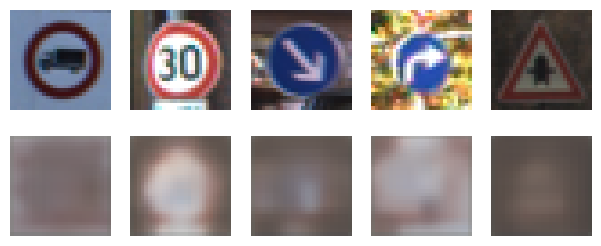

In [81]:
show_reconstructions(autoencoder)

#### They are not the best reconstructions.

# Conclusion

The CNN performed the best as predicted. It had high accuracy and low loss. The ANN had a high loss and high accuracy due to a few categories being misidentified very often. The ANN was confidently wrong in these cases.

The autoencoder can't be compared 1-for-1 with the ANN and CNN since it is doing a different task. The MSE was low, which is good. However, the autoencoder's loss was still high, meaning it was not good at completing the task, which was restoring images. This is most likely do to the model itself. Things could be improved. Perhaps making it simpler would be better. Other layers like Flatten could possibly improve its performance. 